# Data Preparation

In [9]:
from torchvision.datasets import ImageFolder
import os

In [8]:
%pwd

'f:\\end-to-end-deep_learning-project\\research'

In [10]:
os.chdir("../")

In [11]:
%pwd

'f:\\end-to-end-deep_learning-project'

## Apply transforms

In [24]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [25]:
dataset = ImageFolder("train",transform=transform)

In [26]:
len(dataset)

557

## Class names (folder names)

In [27]:
dataset.classes

['cats', 'dogs']

## Class-to-index mapping

In [28]:
dataset.class_to_idx

{'cats': 0, 'dogs': 1}

## Expected shape

torch.Size([3, 224, 224]) → (C, H, W)

In [29]:
img, label = dataset[0]
print(img.shape)      # shape of tensor
print(label)          # numeric label
print(dataset.classes[label])  # class name


torch.Size([3, 224, 224])
0
cats


### Visualize a few images

Label: cats


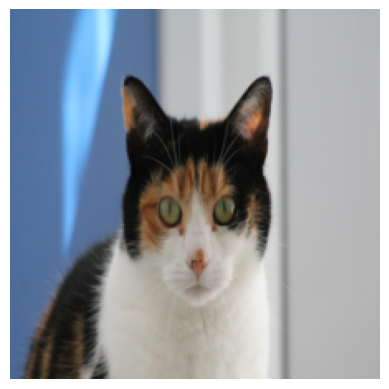

<Figure size 400x400 with 0 Axes>

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def show(img_tensor):
    img = img_tensor.numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.axis("off")
    plt.figure(figsize=(4, 4))

img, label = dataset[10]
show(img)
print("Label:", dataset.classes[label])


## Create train/val split

In [32]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


## Create DataLoaders

In [33]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


## Check one batch

In [34]:
images, labels = next(iter(train_loader))

print(images.shape)  # torch.Size([32, 3, 224, 224])
print(labels.shape)  # torch.Size([32])


torch.Size([32, 3, 224, 224])
torch.Size([32])


## Visualize images in a grid

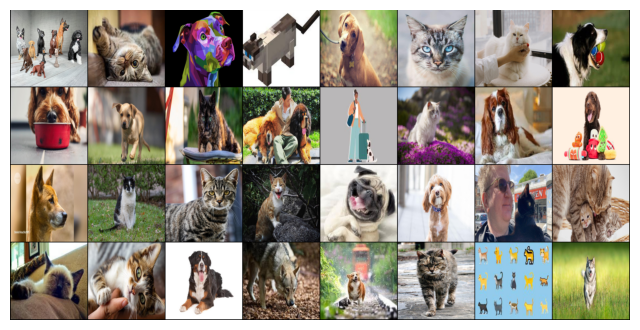

In [37]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Create grid
grid = make_grid(images, nrow=8)   # 4 images per row

# Convert from Tensor (C,H,W) → (H,W,C)
grid_np = grid.permute(1, 2, 0).numpy()

plt.figure(figsize=(8,8))
plt.imshow(grid_np)
plt.axis("off")
plt.show()


## Load pretrained Model (VGG16)

In [ ]:
from torchvision.models import vgg16, VGG16_Weights


weights = VGG16_Weights.DEFAULT
model = vgg16(weights=weights)


for param in model.features.parameters():
  param.requires_grad = False



model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Add Your Custom Head

In [42]:
import torch.nn as nn

num_classes = 2

model.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes)  # final layer
)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Define Loss and Optimizer

⚠ Only the classifier parameters should be optimized

(Because conv layers are frozen)

In [45]:
import torch
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)


In [46]:
for xb , yb in train_loader:
    out = model(xb)
    loss = loss_func(out, yb)
    print(out.shape)
    print(loss)
    break

torch.Size([32, 2])
tensor(0.6822, grad_fn=<NllLossBackward0>)


## Simple Training Loop 

In [54]:
def train_model(model=model,train_loader=train_loader,opt=optimizer,loss_func=loss_func):
    losses = []
    total_samples = 0

    for xb , yb in train_loader:
        
        opt.zero_grad()              # reset gradients

        out = model(xb)
        batch_loss = loss_func(out, yb)

        # update classifier parameter
        batch_loss.backward()        # cal gradients
        opt.step()                   # update parameters
        
        batch_size = len(xb)
        losses.append(batch_loss.item() * batch_size)
        total_samples = total_samples + batch_size

    avg_loss = sum(losses) / total_samples

    return avg_loss 

    
        


In [55]:
epochs = 3
train_losses = []
for epoch in range(epochs):
  loss = train_model(model,train_loader,optimizer,loss_func)
  train_losses.append(loss)
  print(f"Epoch {epoch+1} Loss: {loss:.4f}")

     


Epoch 1 Loss: 0.0309
Epoch 2 Loss: 0.0004
Epoch 3 Loss: 0.0002


Text(0, 0.5, 'loss')

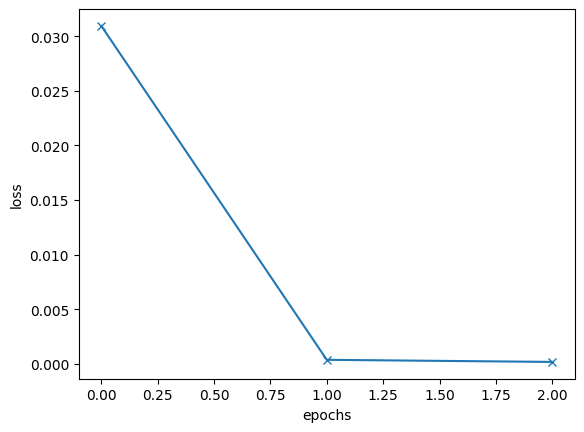

In [56]:
plt.plot(train_losses,"-x")
plt.xlabel('epochs')
plt.ylabel('loss')


## Prediction on test image data

In [57]:
def predict(input_img,label): 
   
   input_batch = input_img.unsqueeze(0)
   out = model(input_batch) # [1,2]
   pred = torch.argmax(out,dim=1).item()
   plt.imshow(input_img.permute(1,2,0))
   # label = test_dataset.classes[label]
   # pred = test_dataset.classes[pred]
   print(f"Actual class : {label} | Predicted class : {pred}")






In [59]:
dataset.class_to_idx

{'cats': 0, 'dogs': 1}

Actual class : 0 | Predicted class : 0


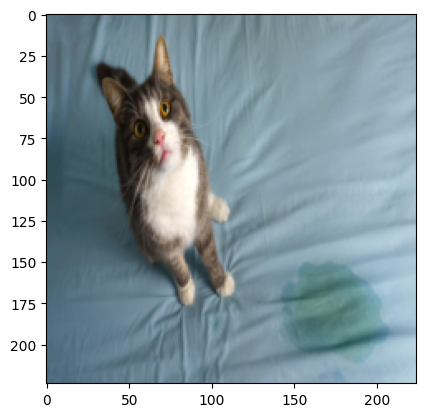

In [58]:
predict(*train_dataset[5])

Actual class : 1 | Predicted class : 1


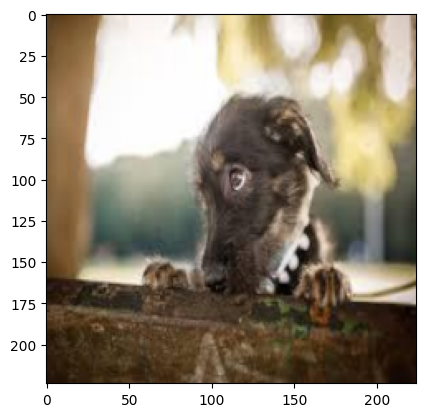

In [60]:
predict(*train_dataset[21])

## Full prediction code

from torchvision import transforms

import torch

model.eval()

# load image

img = Image.open("test.jpg").convert("RGB")

# same transforms as training

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

img = transform(img)

# add batch dimension

img = img.unsqueeze(0)   # (1, 3, 224, 224)

with torch.no_grad():

    output = model(img)

# predicted class index

pred = torch.argmax(output, dim=1).item()

print("Predicted class:", pred)

print("Class name:", dataset.classes[pred])
